## Simulation Settings

In [1]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

# TIS settings
n_moves = 1000              # number of moves to perform for each path ensemble - path ensemble corresponding to each diff interface
n_discard = 50              # number of moves to discard at the beginning of RETIS - we do this to decorrelate new paths from old paths
op_type = 1                 # order parameter;  1:x  2:y  3:x+y
interfaces = [-1.3, -0.8, -0.5, 0.0, 0.5, 1.0, 2.0]
basinA = -2.09              # boundary of basin A; must be less than the first interface
basinB = interfaces[-1]     # basin B defined as last interface
init_coords = [-1, -1]      # initial coordinates
init_p = [0, 0]             # initial momenta
basineqlen = 5000          # basin equilibration length (steps)
basinlen = 50000           # basin simulation length
sigma = 0.5                 # standard deviation of momenta perturbation

#Langevin dynamics settings
beta = 2.5     # 1/kT
gamma = 5.0    # friction
dt = 0.01      # time step size
pes_type = 1   # select the PES type

## Plot PES

<function matplotlib.pyplot.show(close=None, block=None)>

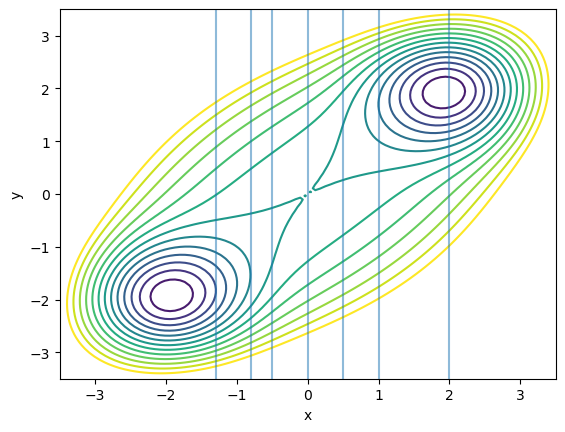

In [2]:
#plot potential energy surface contours
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
X, Y = np.meshgrid(x_vec, y_vec)
energy = np.zeros((N, N))
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])

for xc in interfaces:
    plt.axvline(x=xc,alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.show

# print(energy)

## Simulate in the basin and calculate the flux through the first interface

In [3]:
# Declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)

# Calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma,pes_type)

# Combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma,pes_type)

# Equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma,pes_type)
    basintrajeq = new_basintrajeq
    op = ld.calc_op(op_type,basintrajeq[0],basintrajeq[1])
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

basintraj[0] = basintrajeq
fromBasin = False
n_cross = 0

# Run basin A simulation and check for first crossings
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma,pes_type)
    op = ld.calc_op(op_type,basintraj[j][0],basintraj[j][1])
    if op < basinA:
        fromBasin = True
    if fromBasin == True and op >= interfaces[0]:
        n_cross += 1
        fromBasin = False
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

if n_cross == 0:
    sys.exit("No first crossings obtained from basin A to interface 0. Exiting...")
flux = n_cross/(basinlen*dt)
print("Flux through first interface: {}\n".format(flux))
print("Number of first crossings: {}\n".format(n_cross))


Flux through first interface: 0.014

Number of first crossings: 7



## Generate the initial paths by simulating at a higher temperature

In [4]:
#run at higher temperature to generate an initial path
initpath = []
beta_initpath = 1.5   # this controls the temperature because beta = 1/kb*T
fromBasin = False
#use init_phasepoint to start trajectory
trajstep = ld.vv_step(init_phasepoint,dt,beta_initpath,gamma,pes_type)    # array of x, y, px, py, fx, fy to get the first config to generate a path
op = ld.calc_op(op_type,trajstep[0],trajstep[1])                 # calculate the op to see where this config is at, in A or pass A and cross some lambda, or in B?

while op < basinB:  #as long as it is not in B
    nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma,pes_type)  # generate next config
    trajstep = nextstep                                     # save this config to trajstep, so we could shoot from it again 
    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
    if op < basinA: # if this then this traj is from basin A 
        fromBasin = True
        initpath = []       # reset path if it returns to A - do this until it's about to leave the basin
        trajstep = np.append(trajstep,[op],axis=0)   # array of x, y, px, py, fx, fy and op value
        initpath.append(trajstep) 
        continue
    if op >= basinA and fromBasin == True: # now that you have left basin A, we'll save the different configs to the list initpath
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue

initpath = np.asarray(initpath)
allpaths = [[] for i in range(len(interfaces)-1)] # list of empty lists of size len(interfaces)-1
acc = np.zeros(len(interfaces)-1)  # array of zeros
n_cross = np.zeros(len(interfaces)-1)  

for i in range(len(interfaces)-1):  # loop over amt of interface starting from 0 
    # Find the starting path for interface i
    last_frame = np.where(initpath[:,6] > interfaces[i+1])[0][0] + 1 # np.where returns (which array or) which path that satisfies op > interface that we're crossing
                                                                    # then the [0][0] will give the row number of the x value of the first configuration of the path that satisfies the condition
    allpaths[i].append(initpath[:last_frame]) # continuously append configurations of a path truncated at diff interface
                                              # Ex: allpaths[0] : contains all the paths from A to lambda 0 
                                              #     allpaths[1] : contains all the paths from A to lambda 1 
                                                # at this point, you only have 1 initial path

In [5]:
allpaths[1][0][6] # looks at a configuration (last config of this path)

array([ -2.03739869,  -1.71629321,   0.96027395,  -0.98480697,
         6.84567857, -31.8139587 ,  -2.03739869])

In [6]:
g = allpaths[1][0][:,6] # gives op of each configuration along the first path of interface i 
np.where(g>interfaces[2])[0] # tells me which array or which config crosses interface 2
np.where(g>interfaces[2])[0].shape[0] # tells me how many configs crosses interface 2

1

## Perform TIS

In [5]:
for move in range(1, n_moves):
    for i in range(len(interfaces)-1):
        path = allpaths[i][move-1]
        reject_move = False
        lmax = round((len(path) + 1)/np.random.uniform())
        # Pick random shooting point
        index = np.random.randint(len(path) - 2) + 1 #minus 2 to avoid basinA and i+1 points
        # Perturb the momenta
        shoot_point = copy.deepcopy(path[index])
        shoot_point[2] += np.random.normal(0,sigma)
        shoot_point[3] += np.random.normal(0,sigma)
        trial_path = np.asarray([shoot_point])
        if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
            reject_move = True
        # Integrate backwards path if we have not rejected the move...
        if reject_move == False:
            path_length = 1
            trial_path[:,2] *=-1
            trial_path[:,3] *=-1
            trajstep = copy.deepcopy(trial_path[-1])
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            while op >= basinA:
                trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                trajstep = np.append(trajstep,[op],axis=0)
                trial_path = np.append(trial_path,[trajstep],axis=0)
                path_length +=1
                # Reject if the maximum path length is exceeded
                if path_length > lmax:
                    reject_move = True
                    break
                # Reject if the backward path segment goes to B
                if op >= interfaces[i+1]:
                    reject_move = True
                    break
        if reject_move == False: 
            trial_path = np.flip(trial_path,axis=0)
            trial_path[:,2] *=-1
            trial_path[:,3] *=-1
            trajstep = copy.deepcopy(trial_path[-1])
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            while op >= basinA and op < interfaces[i+1]:
                nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma,pes_type)
                trajstep = nextstep
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                trajstep = np.append(trajstep,[op],axis=0)
                trial_path = np.append(trial_path,[trajstep],axis=0)
                path_length +=1
                if path_length > lmax:
                    reject_move = True
                    break

        # Final chance to reject a path (because no crossing of interface i)
        if np.where(trial_path[:,6]>interfaces[i])[0].shape[0] == 0:
            reject_move = True
        # If we DON'T reject, then path becomes trial path
        if reject_move == False:
            path = trial_path
            acc[i] += 1
        # Here we count the crosses, ignoring all paths before move 50
        if move > n_discard:
            if np.where(path[:,6]>interfaces[i+1])[0].shape[0] > 0:
                n_cross[i] += 1
        allpaths[i].append(path)


In [8]:
np.where(trial_path[:,6] > interfaces[0])[0].shape[0]

trial_path[:,6].shape



(1,)

## Calculate the crossing probabilities and rate constant

Interface 0 acceptance prob: 0.231000
Interface 1 acceptance prob: 0.107000
Interface 2 acceptance prob: 0.072000
Interface 3 acceptance prob: 0.065000
Interface 4 acceptance prob: 0.071000
Interface 5 acceptance prob: 0.053000
Crossing probabilities: [0.07263157894736842, 0.05052631578947368, 0.09789473684210526, 0.19473684210526315, 0.6484210526315789, 0.9547368421052631]
Rate: 1.03944763217402e-06


<function matplotlib.pyplot.show(close=None, block=None)>

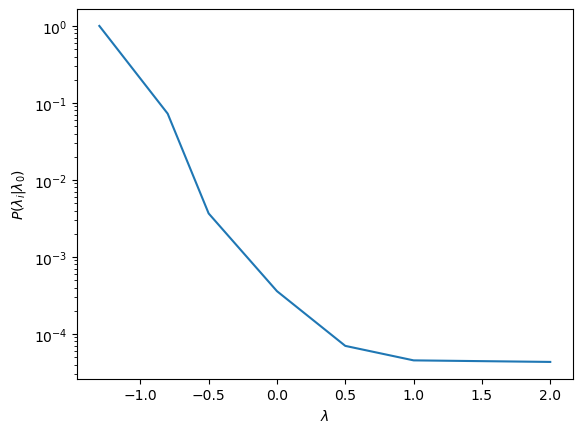

In [6]:
cross_probs = []
for i in range(len(interfaces)-1):
    cross_prob = n_cross[i]/(len(allpaths[i]) - n_discard)
    cross_probs.append(cross_prob)
    print("Interface %d acceptance prob: %f" % (i, acc[i]/n_moves))

rate = flux*np.prod(np.asarray(cross_probs))  # flux from the first crossing * product of crossing probability of all interface
print("Crossing probabilities: {}".format(cross_probs))
print("Rate: {}".format(rate))

#plot cumulative crossing probability
cumuprob = []
for i in range(len(cross_probs)+1):
    cumuprob.append(np.prod(np.asarray(cross_probs[:i]))) # np.asarray(cross_probs[:i]) takes the cross_prob array up until interface i
                                                        # cumuprob[0] then is the probability to cross lambda 0, cumuprob[1] then is the probability to cross lambda 0 AND 1
probs = plt.figure(2)
plt.plot(interfaces,cumuprob)
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('$P(\lambda_i|\lambda_0)$')
plt.show

In [7]:
np.asarray(cross_probs)

cumuprob

np.prod(np.asarray(cross_probs[:0]))

1.0

## Calculate the crossing probability at finer intervals of the order parameter

<function matplotlib.pyplot.show(close=None, block=None)>

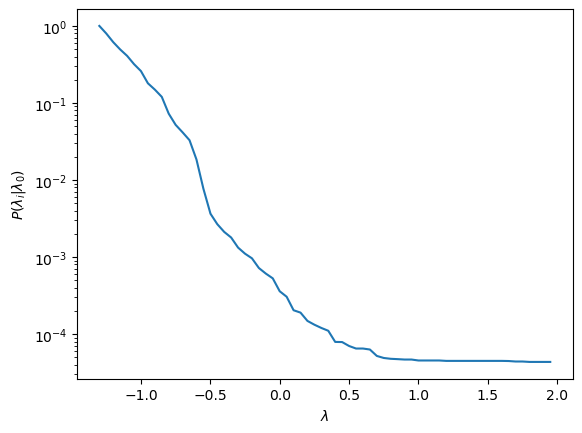

In [8]:
# Plot the crossing probability of lambda at every 0.1 interval instead of at each interface
cumuprob = []
for i in range(len(interfaces)-1):
    for opval in np.arange(interfaces[i], interfaces[i+1], 0.05):
        count = 0
        for path in allpaths[i]:
            if len(np.where(path[:,6] > opval)[0]) > 0: # if there's a path whose op value is higher than the interface it's crossing then, we consider that the path cross that interface
                count += 1
        op_prob = count/(len(allpaths[i])) # for each i, this is calculating the number of crossing of that interface / total number of paths in that interface ensemble
        op_cumuprob = np.prod(np.asarray(cross_probs[:i]))*op_prob
        cumuprob.append([opval, op_cumuprob])
        
cumuprob = np.asarray(cumuprob)
        
probs = plt.figure(2)
plt.plot(cumuprob[:,0],cumuprob[:,1])
plt.yscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('$P(\lambda_i|\lambda_0)$')
plt.show

## Plot the paths collected at each interface

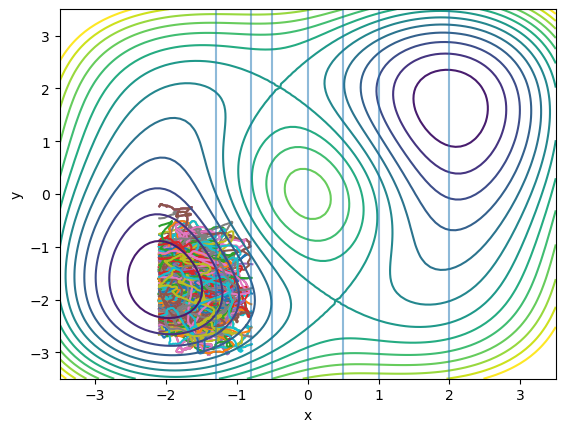

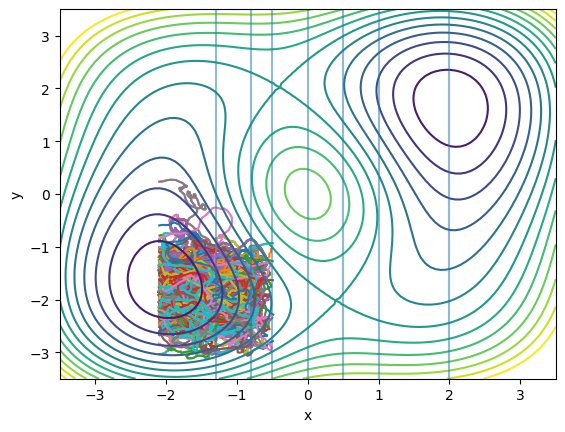

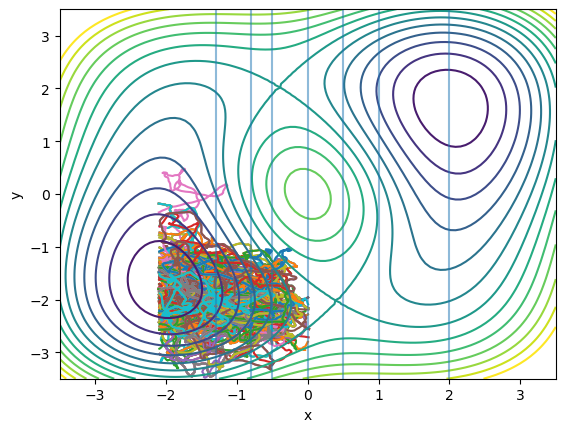

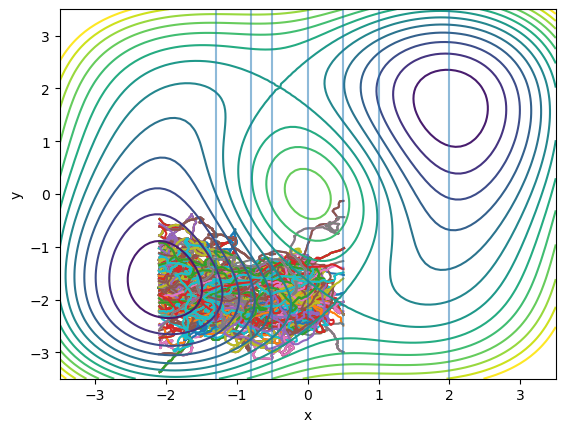

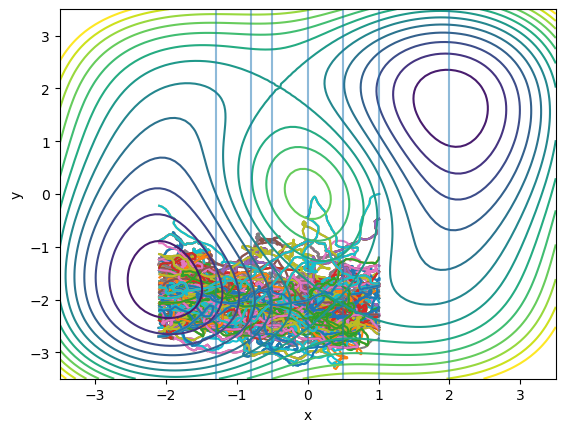

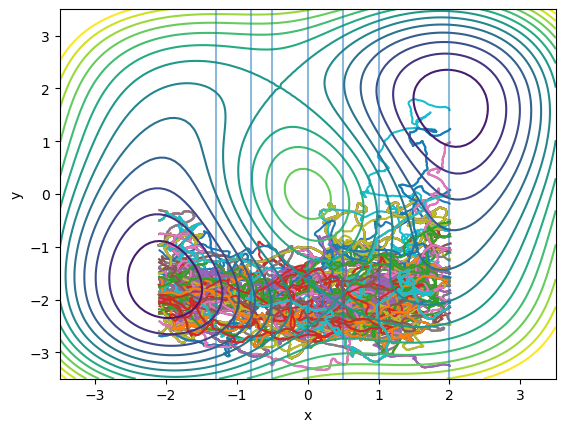

In [9]:
#plot sampled paths from each interface
for i in range(len(interfaces) - 1):
    plt.figure()
    for j in range(0,len(allpaths[i]),5):
        plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1]) # allpaths[i] tells you the interface ensemble you're in, [j] tells you a specific path in that ensemble, [:,0/1] takes all the x/y values of the paths in i
    plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]) # plot the energy landscape/contour
    plt.xlabel('x')
    plt.ylabel('y')
    
    for xc in interfaces:
        plt.axvline(x=xc,alpha=0.5)
        
    plt.show